## Project 1: Predict the Housing Prices in Ames



### Step 0: Load necessary R libraries or Python packages

In [1]:
# install.packages("dplyr")
# install.packages("glmnet")

if (!require("glmnet")) {
  install.packages("glmnet")
}
if (!require("dplyr")) {
  install.packages("dplyr")
}

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Download datasets needed to train two models
# Base URL for the datasets
base_url = "https://raw.githubusercontent.com/e76971072/CS598-Coding2-Datasets/refs/heads/master/Project1/proj1"
# Directory where datasets will be downloaded
download_dir = "datasets"
# List of files to download for each folder
files_to_download = c("test.csv", "test_y.csv", "train.csv")

for (i in 1:10) {
  folder_name = paste0("fold", i)

  fold_dir = file.path(download_dir, folder_name)
  if (!dir.exists(fold_dir)) {
    dir.create(fold_dir, recursive = TRUE)  # Create the directory if it doesn't exist
  }

  # Loop through each file (test.csv, test_y.csv, train.csv)
  for (file_name in files_to_download) {
    # Construct the complete URL for the file
    file_url = paste0(base_url, "/", folder_name, "/", file_name)

    # Construct the local file path where the file will be saved
    local_file = file.path(fold_dir, file_name)

    # Download the file
    if ( !file.exists(local_file)) {
        download.file(file_url, local_file)
    }
    #print(paste("Downloaded:", local_file))
  }
}

setwd("/content/datasets")



### Step 1: Preprocess the training data, then fit the two models.
  - Note: At this step, you are strictly not allowed to access the test data.
  - Solution 1: Ensure that the column names of test.matrix match those of train.matrix, both in name and order. This might involve removing columns representing new levels and appending columns with zeroes for levels present in the training set but absent in the test set. Maintaining the same order is crucial since XGBoost uses numerical matrices, not data frames.

In [3]:
library(dplyr)

DATA_TYPE.TRAIN = "train"
DATA_TYPE.TEST = "test"

#' @func: preprocessing_data
#' @params: data: The data frame to be preprocessed.
#' @notes: This function removes unwanted variables, winsorizes specific numeric columns,
#'           and transforms categorical variables in the data.
#' @returns: A preprocessed data frame.
preprocessing_data = function (data, data_type) {
    print(paste("Data Type:", data_type))

    data_after_remove = variables_to_remove(data)
    data_after_transform = categorical_variables_transform(data_after_remove, data_type)
    dataset = winsorize(data_after_transform)
    return (dataset)
}

#' @func clean_training_data
#' @param : unfilter train_data
#' @Note: data.x should return without "PID" and "Sale_Price"
#' @return: train data
#' sample R code provided by Prof. Liang on campuswire #327
categorical_variables_transform = function (data, data_type) {
      data.x = data
      pid_sale_price = data[c("PID", "Sale_Price")]

      # only remove PID for train data
      if ('PID' %in% colnames(data.x) && tolower(data_type) == tolower(DATA_TYPE.TRAIN)) {
            #cat("inside of categorical_transformation - pid: ", paste(data.pid$PID, collapse = ", "), "\n")
            data.x = data.x %>% select(-PID) # in case of training data, not only remove PID, also need to remove Sale Price later, this store is preparing for the next if condition
      }

       if ('Sale_Price' %in% colnames(data.x)) {
           data.x = data.x %>% select(-Sale_Price)
      }
      # data.x = data %>% select(-PID, -Sale_Price) # train data without "PID" and "Sale_Price"
      # train.y = log(data$Sale_Price)
      data.y = ifelse(!is.na(data$Sale_Price), log(data$Sale_Price), NA) # log transformed "Sale_Price"

      # replace missing by zero
      data.x$Garage_Yr_Blt[is.na(data.x$Garage_Yr_Blt)] = 0

      categorical.vars = colnames(data.x)[
        which(sapply(data.x,
                      function(x) mode(x)=="character"))]
      data.matrix = data.x[, !colnames(data.x) %in% categorical.vars,
                                drop=FALSE]
      n.train = nrow(data.matrix)
      for(var in categorical.vars){
          mylevels = sort(unique(data.x[, var]))
          m = length(mylevels)
          m = ifelse(m > 2, m, 1)
          tmp.train = matrix(0, n.train, m)
          col.names = NULL
          for(j in 1:m){
            tmp.train[data.x[, var]==mylevels[j], j] = 1
            col.names = c(col.names, paste(var, '_', mylevels[j], sep=''))
            }
          colnames(tmp.train) = col.names
          data.matrix = cbind(data.matrix, tmp.train)
        }
   # PID will be stored in data.x$PID if data_type is test, and it will be null if data type is train
  return(list(data.x = data.x, data.y = data.y, data.matrix = data.matrix, original_pid_sale_price = pid_sale_price))
}

#' @func get_train_data
#' @param : from_folder: idataset folder
#' @return: unfilter train data
get_train_data  = function(from_folder = "fold1") {
  data_file   =file.path(from_folder, "train.csv")
  tryCatch({
    data  = read.csv(data_file, header = TRUE)
    return(data)
  }, error = function(e) {
    message("Error reading data:", e$message)
    return(NULL)
  })
}

#' @func get_test_data
#' @param : from_folder: dataset folder
#' @return: unfilter test data
get_test_data  = function(from_folder = "fold1") {
  data_file   =file.path(from_folder, "test.csv")
  tryCatch({
    data  = read.csv(data_file, header = TRUE)
    return(data)
  }, error = function(e) {
    message("Error reading data:", e$message)
    return(NULL)
  })
}

#' @func get_label_data
#' @param : from_folder: interested folder
#' @return: unfilter label data
# Campuswire Project 1 post #328
get_label_data  = function(from_folder = "fold1") {
  data_file   =file.path(from_folder, "test_y.csv")
  tryCatch({
    data  = read.csv(data_file, header = TRUE)
    return(data)
  }, error = function(e) {
    message("Error reading data:", e$message)
    return(NULL)
  })
}

variables_to_remove <- function(train_data, cols_to_remove = c('Street', 'Utilities', 'Condition_2', 'Roof_Matl', 'Heating',
                                                              'Pool_QC', 'Misc_Feature', 'Low_Qual_Fin_SF', 'Pool_Area',
                                                              'Longitude', 'Latitude')) {
  train_data = train_data %>% select(-all_of(cols_to_remove))
  return(train_data)
}


#' @func: winsorize
#' @params : df: The data frame containing the columns to be winsorized.
#' @params :  cols: A vector of column names (default: several numeric columns) to apply the winsorization to.
#' @params  quantile_thresh: The quantile threshold above which values will be capped (default: 0.95, i.e., the 95th percentile).


# winsorize = function(df, cols = c("Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2",
#                       "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", "First_Flr_SF",
#                       "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF",
#                       "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val"),
#                       quantile_thresh = 0.95) {
#       original_train = df
# winsorize = function(x, quantile_value = 0.95) {
#   M = quantile(x, probs = quantile_value, na.rm = TRUE)
#   x[x > M] = M
#   return(x)
# }

#     par(mfrow = c(2, 2))  # Set up 2x2 plot layout for side-by-side comparison
#     copy_data = df
#     for (variable in cols) {

#       # Extract the original and winsorized values for the current column
#       original_var = original_train[[variable]]
#       winsorized_var = copy_data[[variable]]

#       # Set up side-by-side plots for each variable
#       plot(original_var, type = "l", col = "blue", lwd = 2,
#           main = paste("Before Winsorization -", variable),
#           xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

#       plot(winsorized_var, type = "l", col = "red", lwd = 2,
#           main = paste("After Winsorization -", variable),
#           xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

#       # Pause after 2x2 layout is filled, then move to the next set of plots
#       if (which(variable == winsorized_columns) %% 2 == 0) {
#         par(mfrow = c(2, 2))  # Reset for next set of 4 plots
#       }
#     }

#     return(df)
# }



winsorize = function( data , quantile_value = 0.95,  cols = c("Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2",
                      "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", "First_Flr_SF",
                      "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF",
                      "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val"),
                      quantile_thresh = 0.95) {


  tempData = data
  for(var in cols) {
    x = tempData [[var]]
    M = quantile(x, probs = quantile_value, na.rm = TRUE)
    x[x > M] = M
    tempData[[var]] = x
  }


    # par(mfrow = c(2, 2))  # Set up 2x2 plot layout for side-by-side comparison
    # for (variable in cols) {

    #   # Extract the original and winsorized values for the current column
    #   original_var = data[[variable]]
    #   winsorized_var = tempData[[variable]]

    #   # Set up side-by-side plots for each variable
    #   plot(original_var, type = "l", col = "blue", lwd = 2,
    #       main = paste("Before Winsorization -", variable),
    #       xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

    #   plot(winsorized_var, type = "l", col = "red", lwd = 2,
    #       main = paste("After Winsorization -", variable),
    #       xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

    #   # Pause after 2x2 layout is filled, then move to the next set of plots
    #   if (which(variable == winsorized_columns) %% 2 == 0) {
    #     par(mfrow = c(2, 2))  # Reset for next set of 4 plots
    #   }
    # }
  return (tempData)

}




#' @func: full_join_data
#' @params: data1: The first data frame.
#' @params: data2: The second data frame to be joined.
#' @params: col: The column name (default 'PID') on which to perform the full join.
#' @notes: This function performs a full join of two data frames based on the given column,
#'           keeping all rows from the first data frame.
#' @returns: A data frame containing the full join of data1 and data2.
full_join_data = function (data1, data2, col= 'PID' ) {
     merge(data1, data2, by = col , all.x = TRUE)
}


#' @func: load_and_fetch_data_type
#' @params: from_folder: The directory where the data is stored.
#' @params: data_type: The type of data to be loaded (either 'test' or other types).
#' @notes: This function loads and preprocesses data depending on the specified data type.
#'           If the type is 'test', it will load the test data and labels, join them, and preprocess.
#'           Otherwise, it loads the training data and preprocesses it.
#' @returns: A preprocessed data frame based on the specified data type.
load_and_fetch_data_type = function (from_folder, data_type ) {
    print(paste("Loading and processing", data_type, "data"))

  if (tolower(data_type) == tolower(DATA_TYPE.TEST)) {
      original_test_data = get_test_data(from_folder)
      original_test_label = get_label_data(from_folder)
      test_data = full_join_data(original_test_data, original_test_label)
      test_data = preprocessing_data(data = test_data, data_type = data_type)  # Pass data_type here
      return (test_data)
  } else {
      original_train_data = get_train_data(from_folder)
      train_data = preprocessing_data(data = original_train_data, data_type = data_type)  # Pass data_type here
      return (train_data)
  }
}




In [4]:
# how to get train, test and test_y data from respective folder
# Load training data and clean it
# Project 1: What We Have Tried (II) # 328
# load train data
# following steps as follows :
#     1. load fold#/train.csv
#     2. Variables remove
#     3. Wintorization
#     4. categorical_variables_transform



# LOAD Test Data
# step 1: Load test.csv
# step 2: load test_y.csv
# step 3: full_join_on test.csv and test_y.csv based on PID to get Sale_Price label
# Step 4:
#     4a. load fold#/train.csv
#     4b. Variables remove
#     4c. Wintorization
#     4d. categorical_variables_transform


# -------------- Sanity check after Categorical Variables --------------------------
Common Columns:
 [1] "PID"                "MS_SubClass"        "MS_Zoning"         
 [4] "Lot_Frontage"       "Lot_Area"           "Alley"             
 [7] "Lot_Shape"          "Land_Contour"       "Lot_Config"        
[10] "Land_Slope"         "Neighborhood"       "Condition_1"       
[13] "Bldg_Type"          "House_Style"        "Overall_Qual"      
[16] "Overall_Cond"       "Year_Built"         "Year_Remod_Add"    
[19] "Roof_Style"         "Exterior_1st"       "Exterior_2nd"      
[22] "Mas_Vnr_Type"       "Mas_Vnr_Area"       "Exter_Qual"        
[25] "Exter_Cond"         "Foundation"         "Bsmt_Qual"         
[28] "Bsmt_Cond"          "Bsmt_Exposure"      "BsmtFin_Type_1"    
[31] "BsmtFin_SF_1"       "BsmtFin_Type_2"     "BsmtFin_SF_2"      
[34] "Bsmt_Unf_SF"        "Total_Bsmt_SF"      "Heating_QC"        
[37] "Central_Air"        "Electrical"         "First_Flr_SF"      
[40] "Second_Fl

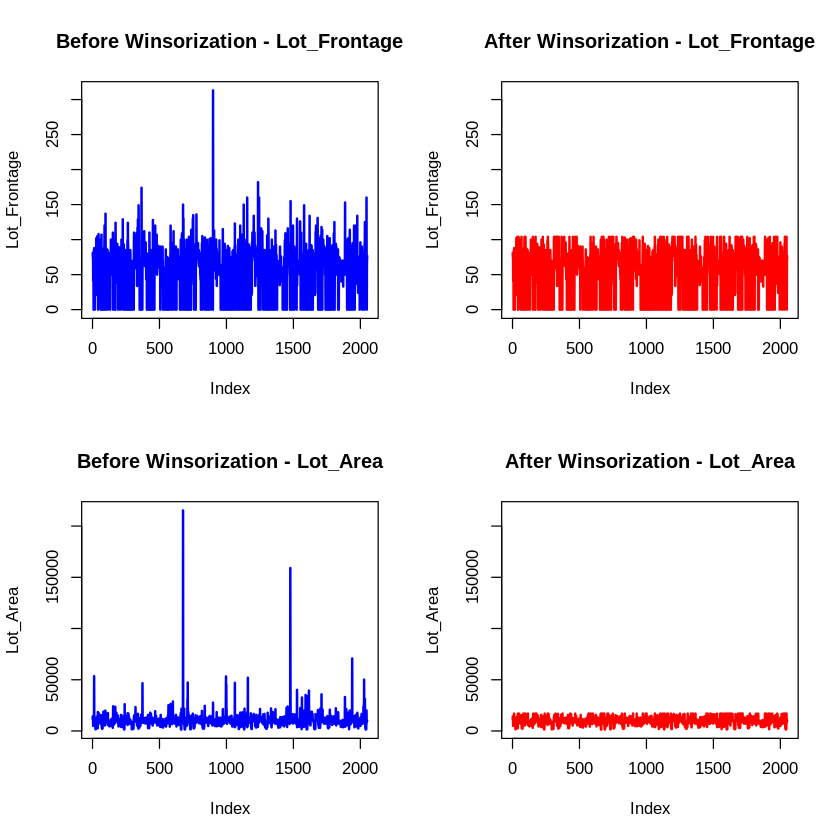

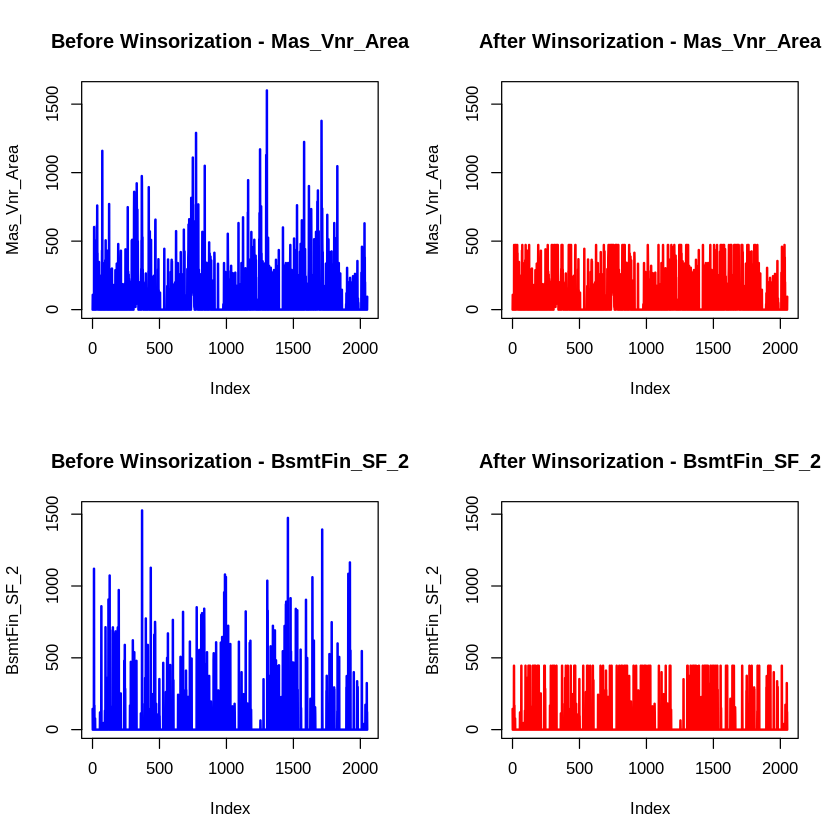

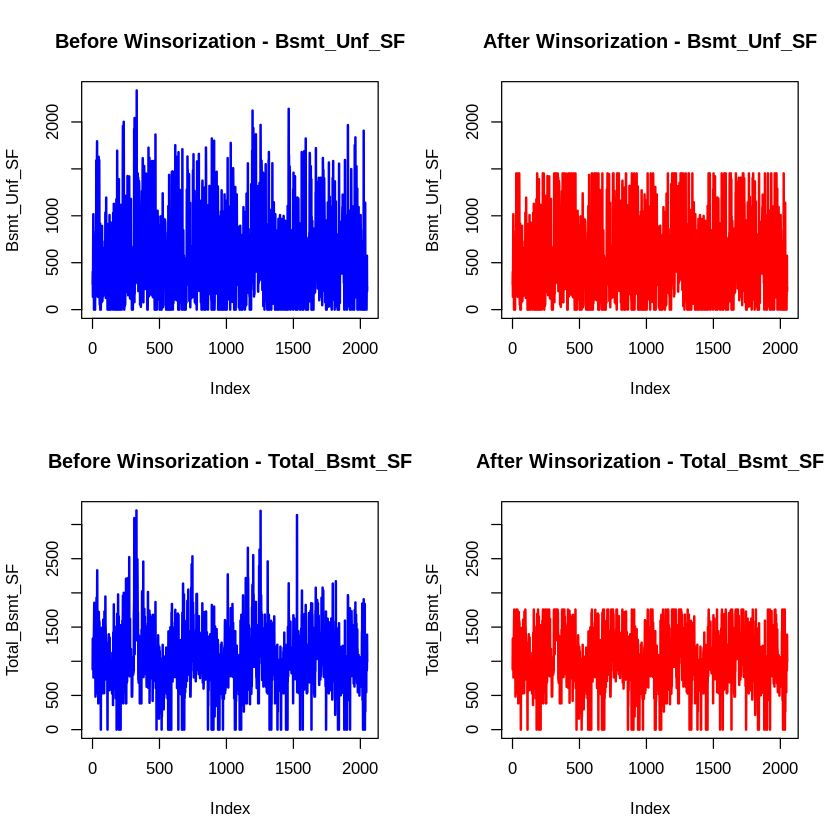

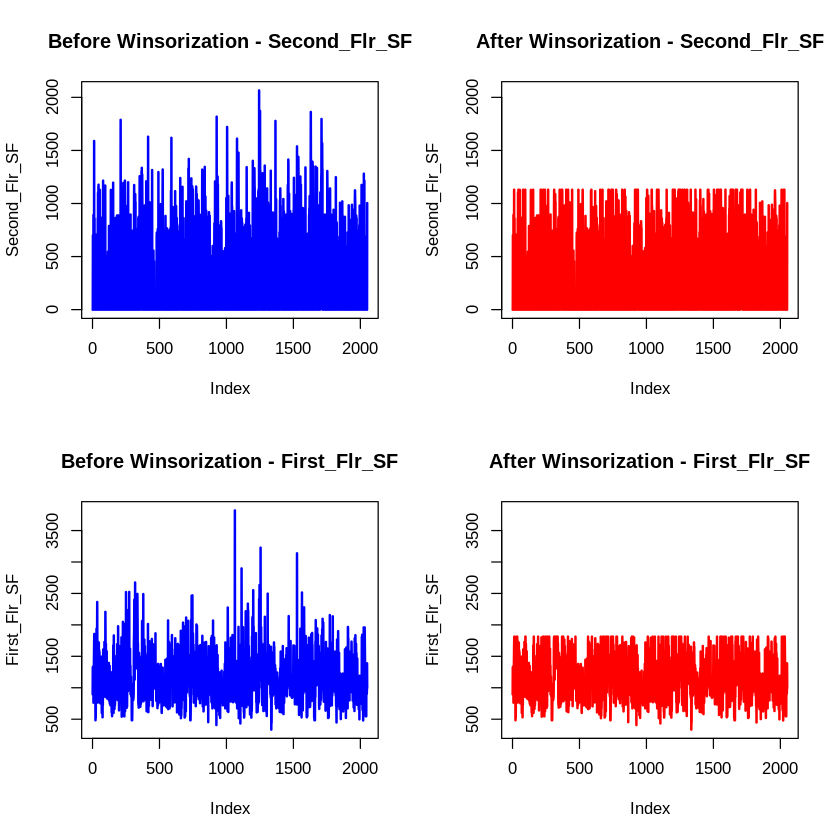

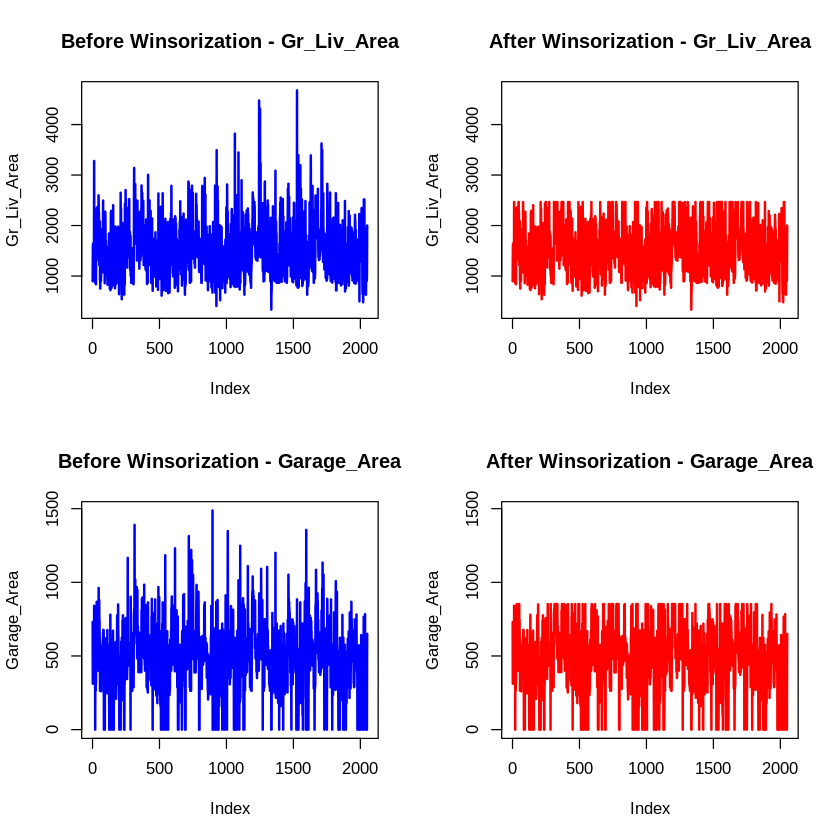

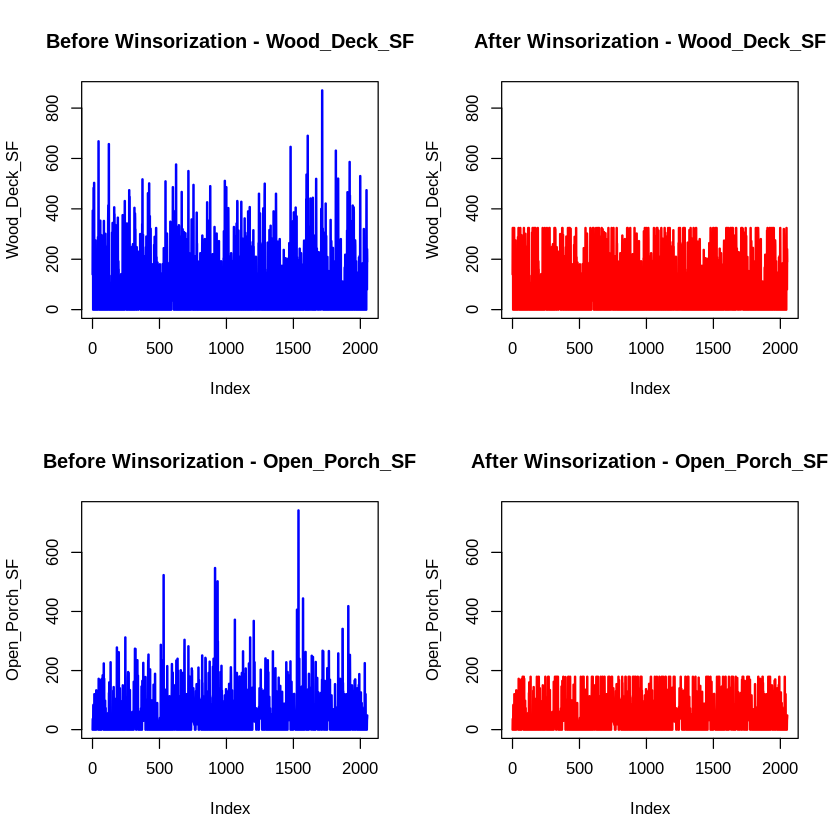

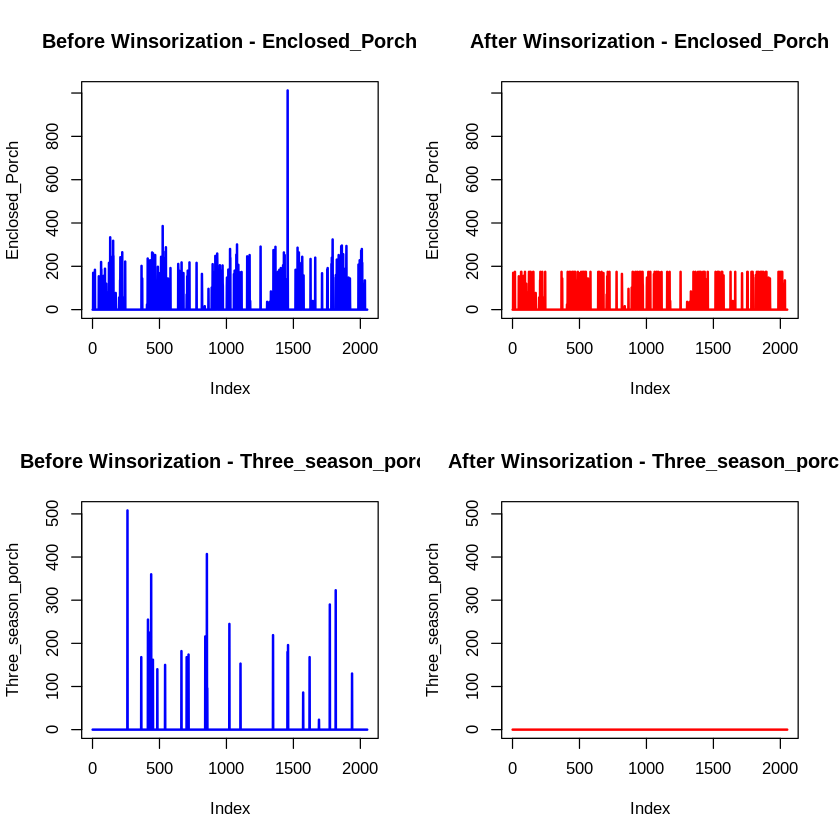

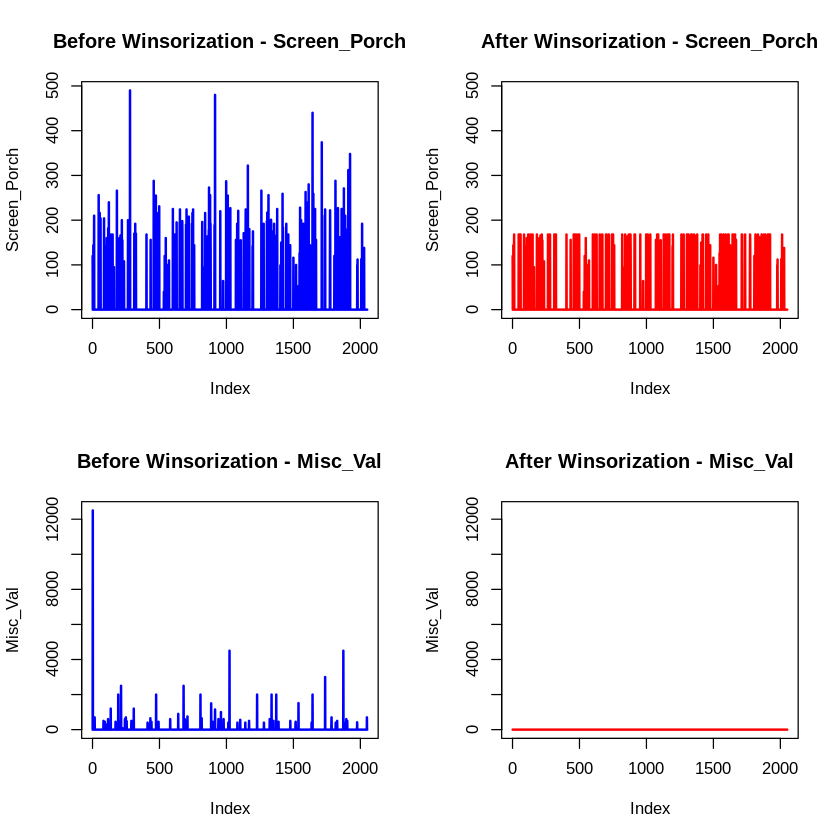

In [5]:

# Load Original Test/Train file
originalTraindata = get_train_data("fold1")




after_variable_remove = variables_to_remove( originalTraindata)


# --------------------- Sanity Check after Variables_remove ---------------------
original_cols = colnames(originalTraindata)
variable_remove_cols = colnames(after_variable_remove)

# Identify common columns
common_cols = intersect(original_cols, variable_remove_cols)

# Identify columns only in original_train
only_in_original = setdiff(original_cols, variable_remove_cols)

# Identify columns only in copy_data
only_in_copy = setdiff(variable_remove_cols, original_cols)

cat ("# -------------- Sanity check after Categorical Variables --------------------------\n")
cat("Common Columns:\n")
print(common_cols)

cat("\nColumns removed from original_data:\n")
print(only_in_original)




# -------------- Sanity check after Categorical Variables --------------------------


cat ("\n#-------------- Sanity check after Categorical Variables --------------------------\n")

cat("\nOriginal Dimension:\n")
print(dim(originalTraindata))



after_categorical_variables_train = categorical_variables_transform(originalTraindata, DATA_TYPE.TEST)


cat("After categorical_variables_transform Dimension Data.x :\n")
print(dim(after_categorical_variables_train$data.x))

cat("After categorical_variables_transform Dimension Data.y :\n")
print(dim(after_categorical_variables_train$data.y))


cat("After categorical_variables_transform Dimension Data.matrix :\n")
print(dim(after_categorical_variables_train$data.matrix))

cat("After categorical_variables_transform Dimension Original PID & SALE_PRICE :\n")
print(dim(after_categorical_variables_train$original_pid_sale_price))

# -------------- Sanity check after Winsorize --------------------------


cat ("\n# -------------- Sanity check after Winsorize --------------------------\n")

winsorized_train_data  = winsorize(originalTraindata)


winsorized_columns = c("Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2",
                      "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", "First_Flr_SF",
                      "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF",
                      "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val")

# Loop over the columns and generate plots
par(mfrow = c(2, 2))  # Set up 2x2 plot layout for side-by-side comparison

for (variable in winsorized_columns) {

  # Extract the original and winsorized values for the current column
  original_var = originalTraindata[[variable]]
  winsorized_var = winsorized_train_data[[variable]]

  # Set up side-by-side plots for each variable
  plot(original_var, type = "l", col = "blue", lwd = 2,
       main = paste("Before Winsorization -", variable),
       xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

  plot(winsorized_var, type = "l", col = "red", lwd = 2,
       main = paste("After Winsorization -", variable),
       xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

  # Pause after 2x2 layout is filled, then move to the next set of plots
  if (which(variable == winsorized_columns) %% 2 == 0) {
    par(mfrow = c(2, 2))
  }
}





# -------------- Sanity check after Categorical Variables (Test) --------------------------
Common Columns:
 [1] "PID"                "MS_SubClass"        "MS_Zoning"         
 [4] "Lot_Frontage"       "Lot_Area"           "Alley"             
 [7] "Lot_Shape"          "Land_Contour"       "Lot_Config"        
[10] "Land_Slope"         "Neighborhood"       "Condition_1"       
[13] "Bldg_Type"          "House_Style"        "Overall_Qual"      
[16] "Overall_Cond"       "Year_Built"         "Year_Remod_Add"    
[19] "Roof_Style"         "Exterior_1st"       "Exterior_2nd"      
[22] "Mas_Vnr_Type"       "Mas_Vnr_Area"       "Exter_Qual"        
[25] "Exter_Cond"         "Foundation"         "Bsmt_Qual"         
[28] "Bsmt_Cond"          "Bsmt_Exposure"      "BsmtFin_Type_1"    
[31] "BsmtFin_SF_1"       "BsmtFin_Type_2"     "BsmtFin_SF_2"      
[34] "Bsmt_Unf_SF"        "Total_Bsmt_SF"      "Heating_QC"        
[37] "Central_Air"        "Electrical"         "First_Flr_SF"      
[40] "Se

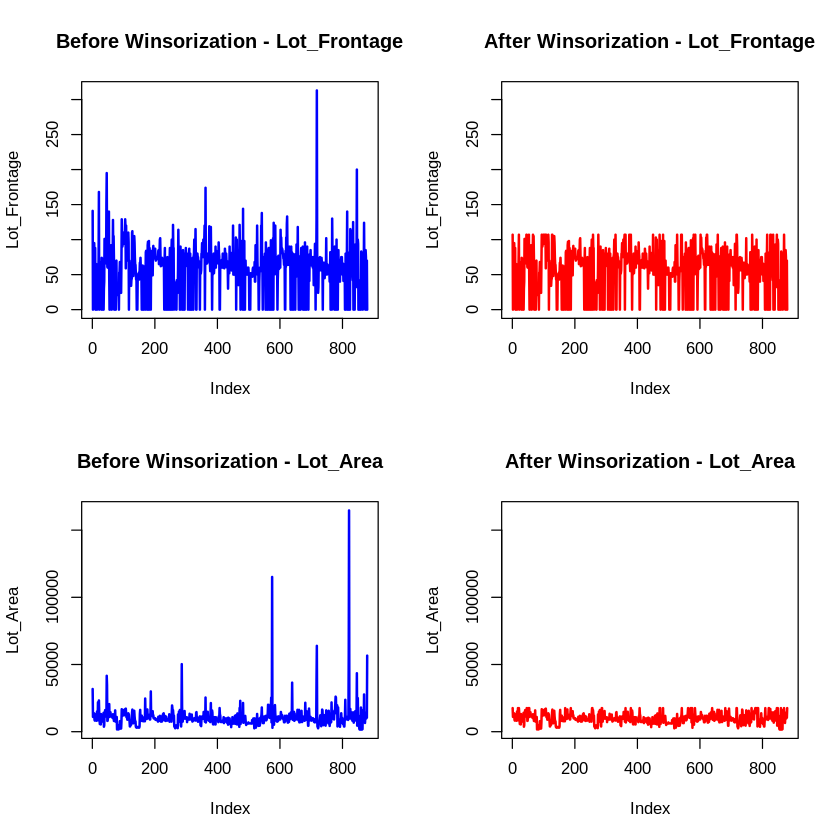

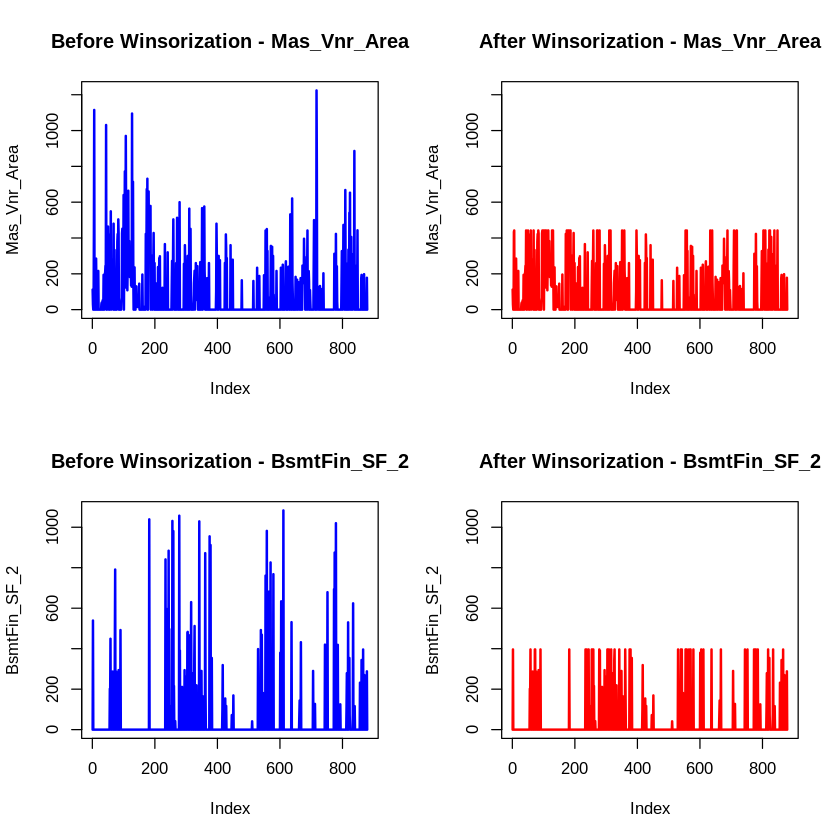

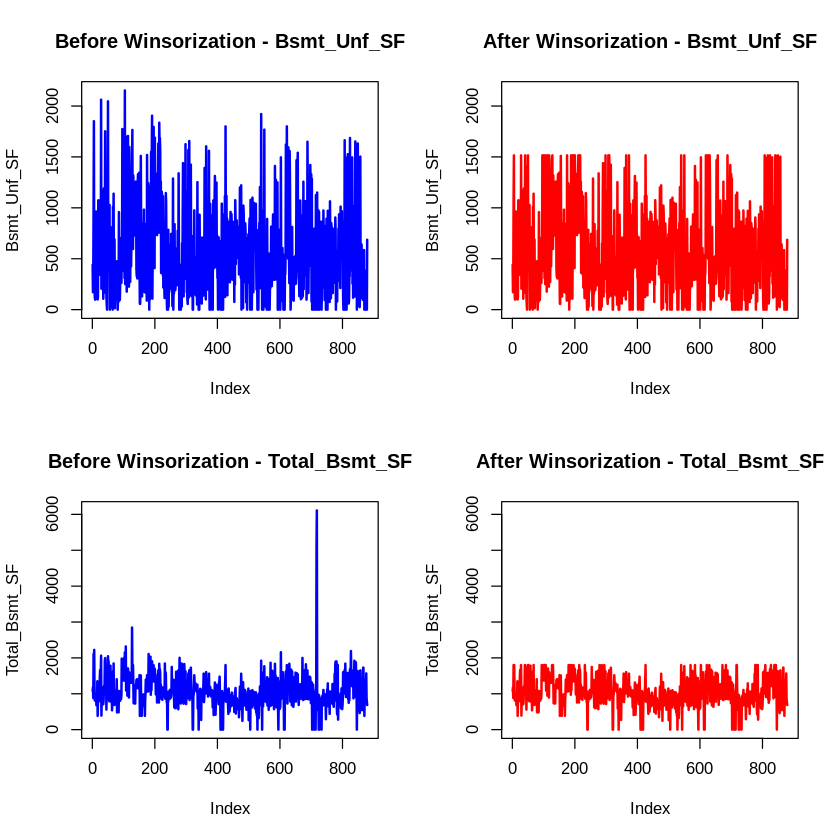

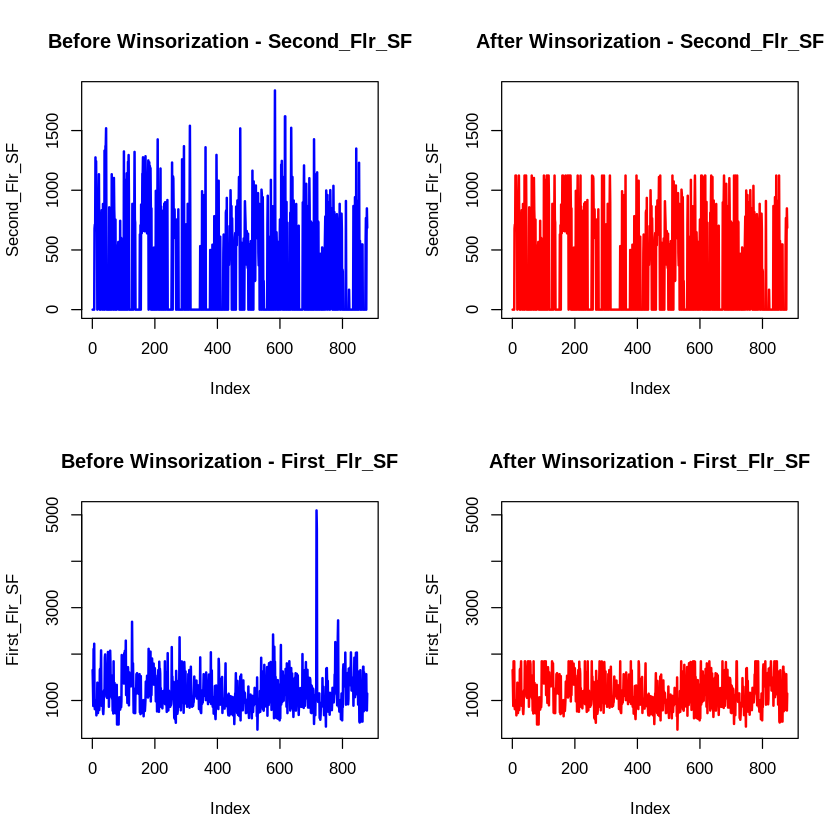

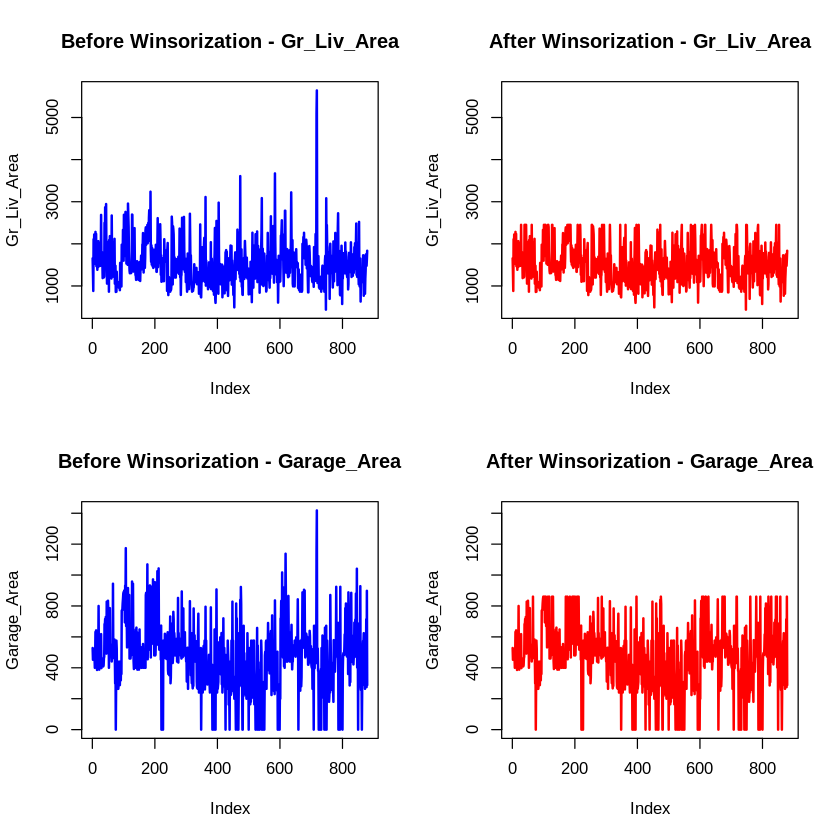

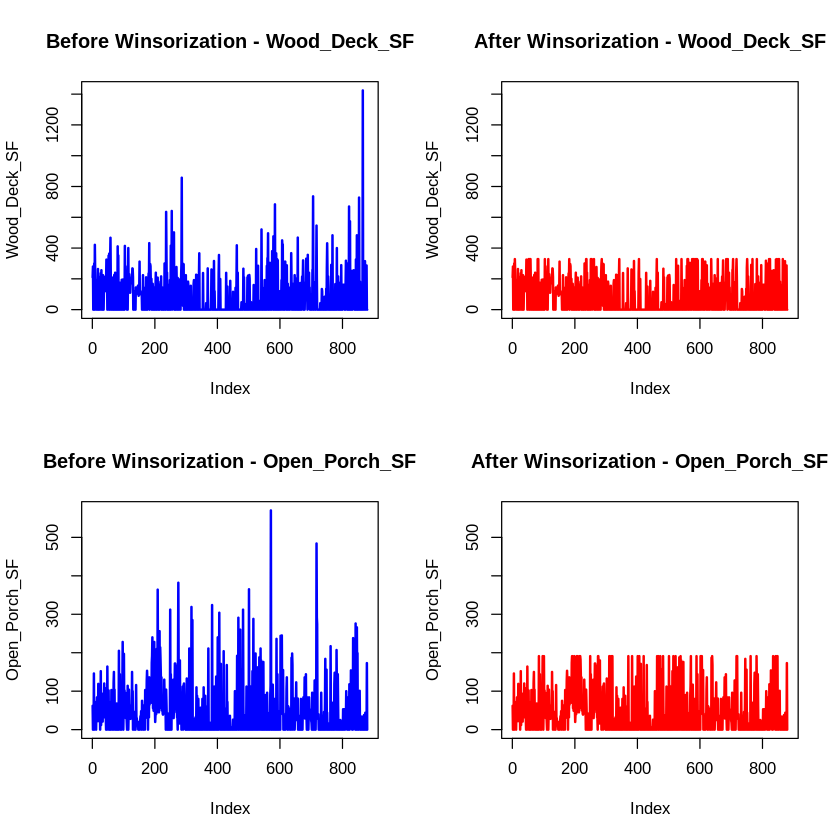

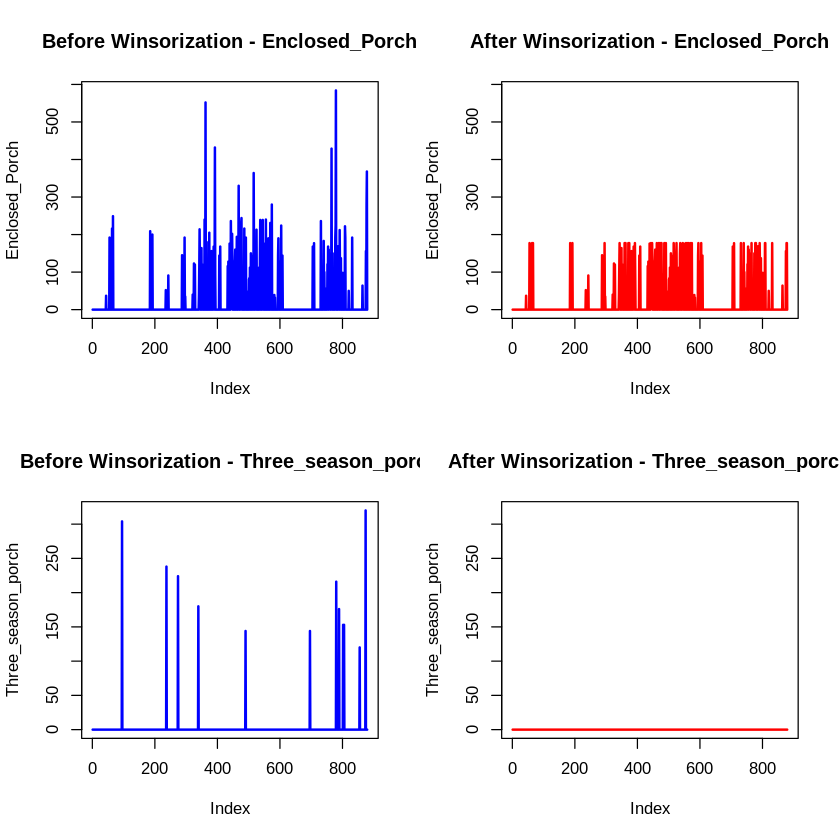

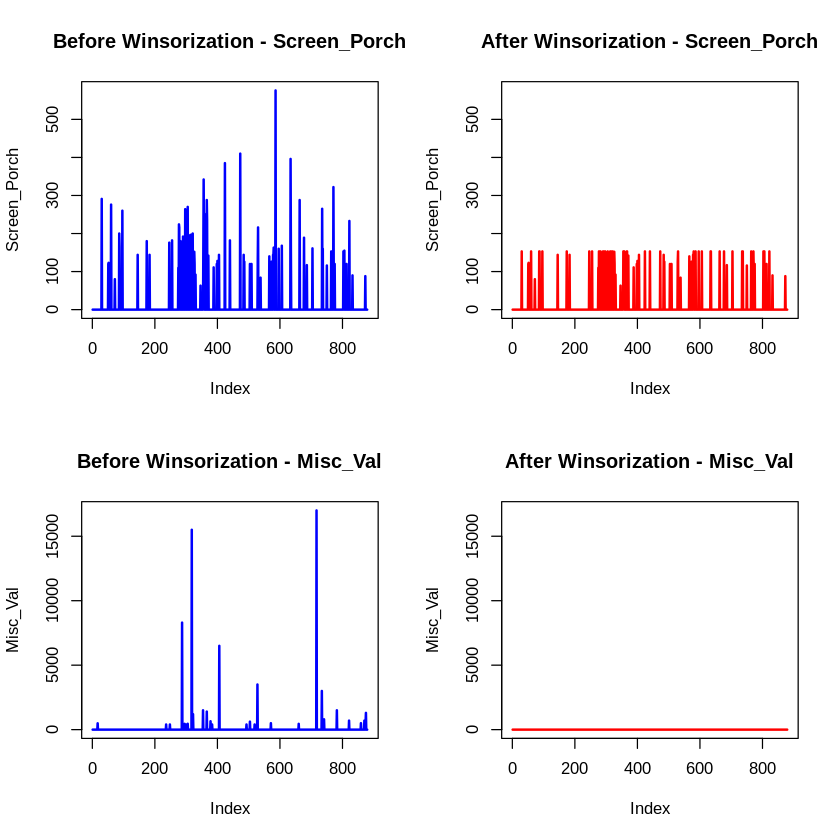

In [6]:
# Load original test data
originalTestData = get_test_data("fold1")

testData = full_join_data( originalTestData, get_label_data("fold1"))
# Remove unnecessary variables from test data
after_variable_remove_test = variables_to_remove(testData)

# --------------------- Sanity Check after Variables_remove ---------------------
test_original_cols = colnames(testData)
test_variable_remove_cols = colnames(after_variable_remove_test)

# Identify common columns
test_common_cols = intersect(test_original_cols, test_variable_remove_cols)

# Identify columns only in original test
only_in_original_test = setdiff(test_original_cols, test_variable_remove_cols)

# Identify columns only in copy_data
only_in_copy_test = setdiff(test_variable_remove_cols, test_original_cols)

cat ("# -------------- Sanity check after Categorical Variables (Test) --------------------------\n")
cat("Common Columns:\n")
print(test_common_cols)

cat("\nColumns removed from original_test_data:\n")
print(only_in_original_test)

# -------------- Sanity check after Categorical Variables --------------------------

cat ("\n#-------------- Sanity check after Categorical Variables (Test) --------------------------\n")

cat("\nOriginal Dimension (Test Data):\n")
print(dim(testData))

after_categorical_variables_test = categorical_variables_transform(testData, DATA_TYPE.TEST)

cat("After categorical_variables_transform Dimension Test Data.x :\n")
print(dim(after_categorical_variables_test$data.x))

cat("After categorical_variables_transform Dimension Test Data.y :\n")
print(dim(after_categorical_variables_test$data.y))

cat("After categorical_variables_transform Dimension Test Data.matrix :\n")
print(dim(after_categorical_variables_test$data.matrix))

cat("After categorical_variables_transform Dimension Original PID & SALE_PRICE (Test):\n")
print(dim(after_categorical_variables_test$original_pid_sale_price))

# -------------- Sanity check after Winsorize --------------------------

cat ("\n# -------------- Sanity check after Winsorize (Test Data) --------------------------\n")

winsorized_test_data = winsorize(testData)

# Loop over the columns and generate side-by-side plots for winsorization in the test data
par(mfrow = c(2, 2))  # Set up 2x2 plot layout for side-by-side comparison

for (variable in winsorized_columns) {

  # Extract the original and winsorized values for the current column
  original_var = testData[[variable]]
  winsorized_var = winsorized_test_data[[variable]]

  # Set up side-by-side plots for each variable
  plot(original_var, type = "l", col = "blue", lwd = 2,
       main = paste("Before Winsorization -", variable),
       xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

  plot(winsorized_var, type = "l", col = "red", lwd = 2,
       main = paste("After Winsorization -", variable),
       xlab = "Index", ylab = variable, ylim = range(c(original_var, winsorized_var)))

  # Pause after 2x2 layout is filled, then move to the next set of plots
  if (which(variable == winsorized_columns) %% 2 == 0) {
    par(mfrow = c(2, 2))
  }
}


In [7]:
# performing train matrix vs test matrix diff column name

# Solution 1: Ensure that the column names of test.matrix match those of train.matrix, both in name and order. This might involve removing columns representing new levels and appending columns with zeroes for levels present in the training set but absent in the test set. Maintaining the same order is crucial since XGBoost uses numerical matrices, not data frames.

# Find common column names between train and test
common_columns = intersect(colnames(winsorized_train_data$data.matrix), colnames(winsorized_test_data$data.matrix))

# Subset test$data.matrix to retain only the common columns
winsorized_test_data$data.matrix = winsorized_test_data$data.matrix[, common_columns, drop = FALSE]

# Sort the common columns in alphabetical order
common_columns_sorted = sort(common_columns)

# Reorder both train and test matrices based on sorted column names
winsorized_train_data$data.matrix$data.matrix = winsorized_train_data$data.matrix[, common_columns_sorted, drop = FALSE]
winsorized_test_data$data.matrix = winsorized_test_data$data.matrix[, common_columns_sorted, drop = FALSE]

# checking  column Names
identical(colnames(winsorized_test_data$data.matrix), colnames(winsorized_train_data$data.matrix))

# checking  Dimension
identical(dim(winsorized_test_data$data.matrix), dim(winsorized_train_data$data.matrix))


[1] TRUE

[1] TRUE

In [8]:
library(glmnet)

# narrow down parameters with Lasso
lasso_feature_selection = function(inputs, response) {
  # Fit the Lasso model
  set.seed(123)  # For reproducibility
  lasso_model = glmnet(inputs, response, alpha = 1)

  # Cross-validate to find the optimal lambda
  cv_model = cv.glmnet(inputs, response, alpha = 1)
  best_lambda = cv_model$lambda.min

  # Extract coefficients using the best lambda
  lasso_coefs = coef(cv_model, s = "lambda.min")

  # Convert lasso_coefs to a vector
  lasso_coefs_vector = as.vector(lasso_coefs)

  # Identify selected features (non-zero coefficients)
  selected_features = rownames(lasso_coefs)[lasso_coefs_vector != 0]

  # Remove the intercept if present
  selected_features = selected_features[selected_features != "(Intercept)"]

  # Return the selected features
  return(selected_features)
}

# fit with Ridge
ridge_y_hat = function(X, y, features) {

  # Define a sequence of lambda values for cross-validation
  myridge_lambda_seq = exp(seq(-10, 1, length.out = 100))

  # Perform cross-validation to find the best lambda for Ridge regression
  cv_out = cv.glmnet(X, y, alpha = 0, lambda = myridge_lambda_seq)
  best_lam = cv_out$lambda.min

  # Make predictions on the training data
  predictions = predict(cv_out, s = best_lam, newx = X[, features])

  # Return the predictions
  return(predictions[, 1])  # Return the first column of predictions
}

In [9]:
# original_train_data = read.csv("datasets/fold1/train.csv")
original_train_data = get_train_data("fold1")

dim(original_train_data)

# load train data
train_data_processed = load_and_fetch_data_type(from_folder = "fold1", data_type = DATA_TYPE.TRAIN)
train.y = train_data_processed$data.y
train.matrix = train_data_processed$data.matrix

train_X = as.matrix(train_data_processed$data.matrix)
train_y = as.vector(train_data_processed$data.y)

# Check dimensions
print(dim(train_X))
print(length(train_y))

# use Lasso to narrow down feature selection
selected_features = lasso_feature_selection(train_X, train_y)
num_selected_features = length(selected_features)
total_features = ncol(train_X)
num_selected_features = length(selected_features)
num_zeroed_out_features = total_features - num_selected_features

cat("Total features:", total_features, "\n")
cat("Selected features:", num_selected_features, "\n")
cat("Zeroed-out features:", num_zeroed_out_features, "\n")


# log_prediction = ridge_y_hat(train_X, train_y, selected_features)
# RMSE = sqrt(mean((original_test_data_y$Sale_Price - unlogged_test_estimates)^2))
# cat("RMSE:", RMSE, "\n")


[1] 2051   83

[1] "Loading and processing train data"
[1] "Data Type: train"
[1] 2051  308
[1] 2051
Total features: 308 
Selected features: 139 
Zeroed-out features: 169 


Performance Target. Your performance is based on RMSE from the two models. Full credit for submissions with RMSEs less than

 - 0.125 for the initial 5 training/test splits and

 - 0.135 for the subsequent 5 training/test splits.

[1] "Loading and processing test data"
[1] "Data Type: test"
PID: 908154195 
Gr_Liv_Area: 5095 
test_y dim: 
length of y estimates:  879 
length of true y:  879 
unlogged_test_estimates: 879 
           PID predicted_y Sale_Price
1    526301100      188623     215000
2    526302030      155385     149900
3    526302110      116095     124500
4    526353030      253261     244000
5    526354020      188474     192100
6    526355170      249883     244000
7    527105050      177966     187500
8    527105060      190372     183500
9    527105070      185070     189500
10   527105130      265074     270000
11   527105140      217564     225000
12   527106010      205276     222000
13   527106050      174051     165000
14   527106150      208206     192000
15   527107010      177636     173000
16   527107090      182142     177900
17   527107130      178899     189000
18   527107210      197124     175000
19   527108030      246998     250000
20   527108040      251207     239900
21   52710

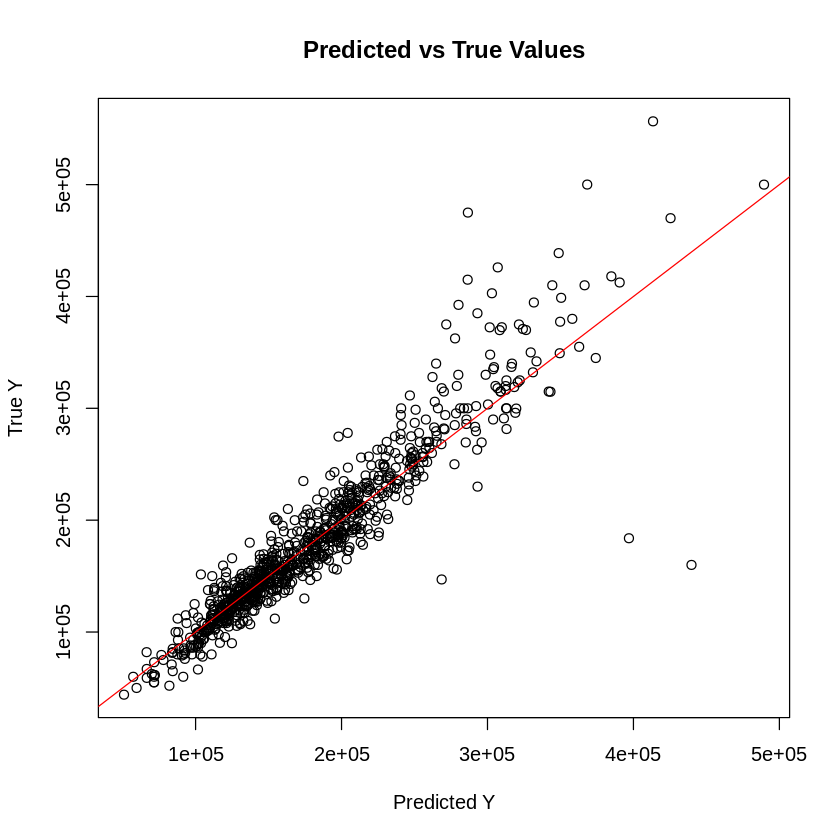

Maximum Residual: 279780 
PID of Outlier: 908154235 


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


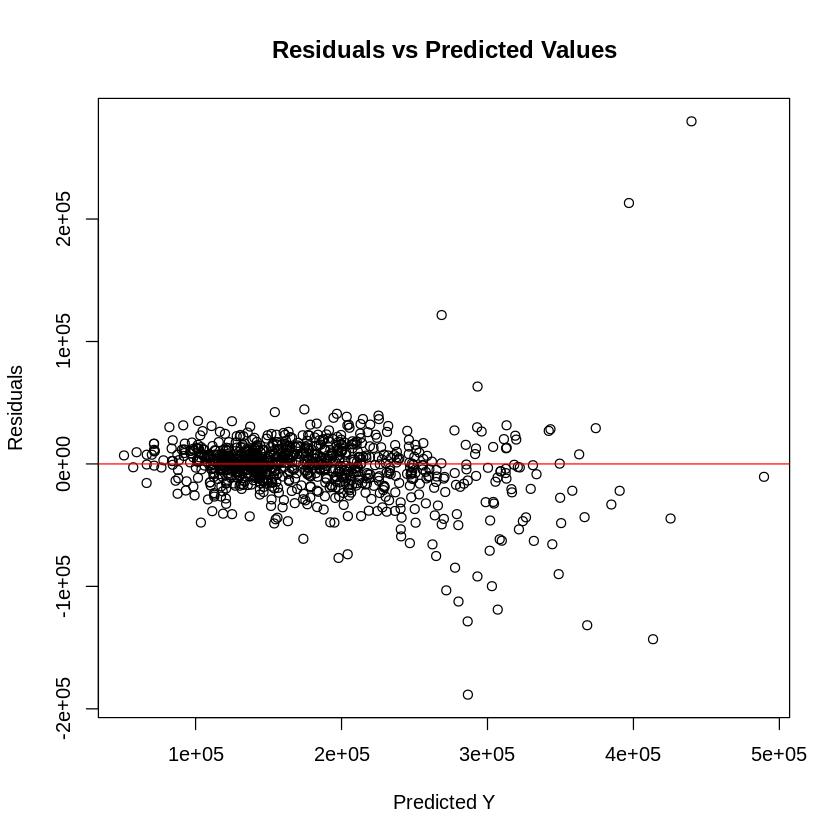

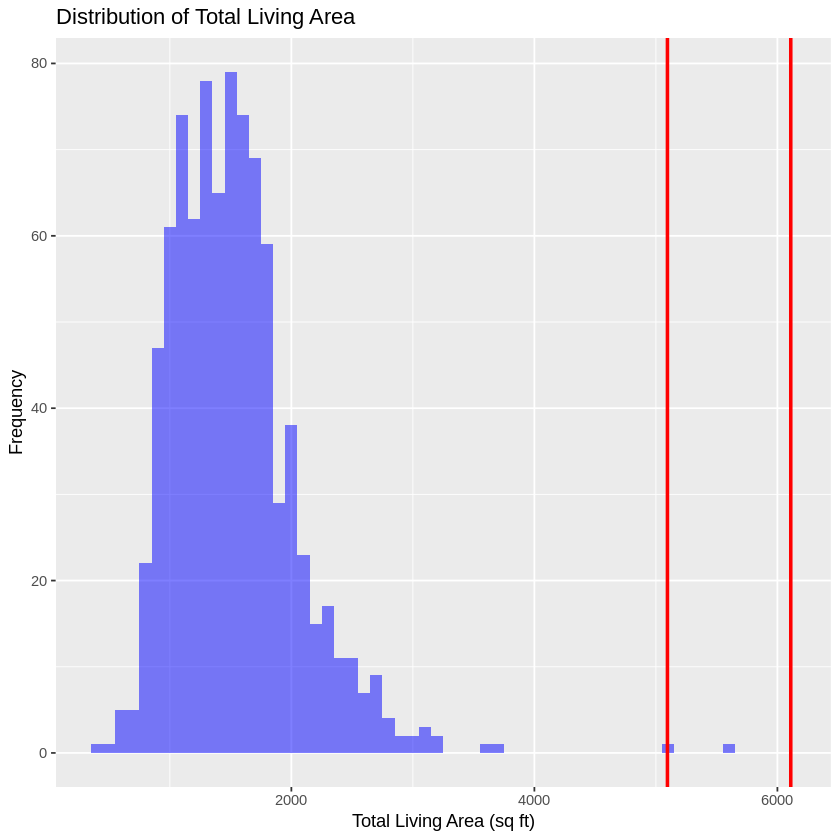

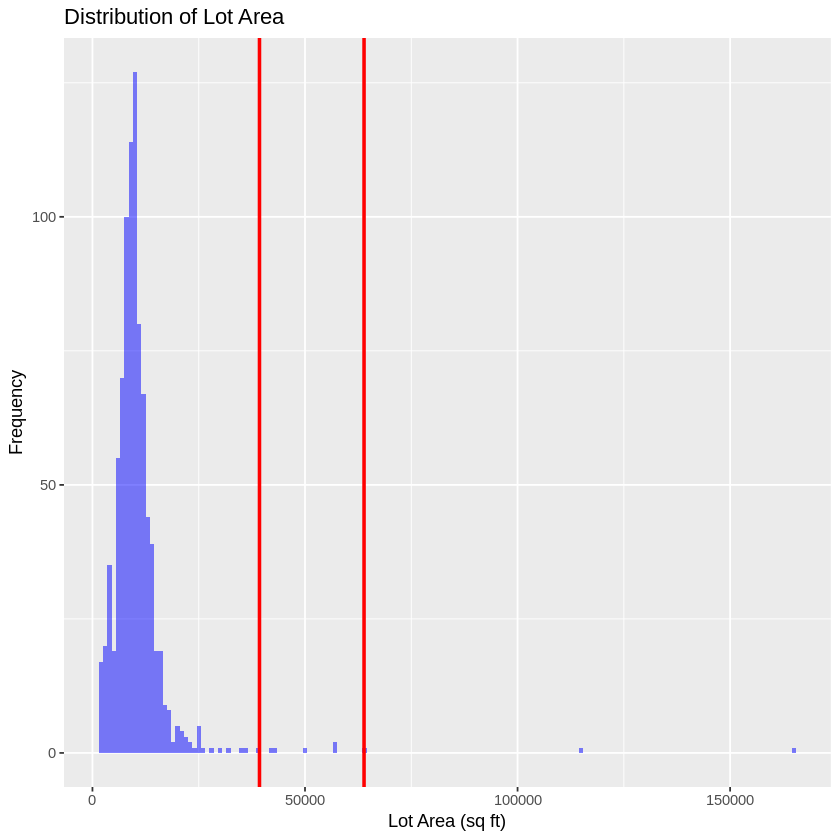

In [11]:
# comment out for now: # pending on testing data from Kevin
library(ggplot2)
test_data_processed = load_and_fetch_data_type(from_folder = "fold1", data_type = DATA_TYPE.TEST)
test.y = test_data_processed$data.y  # logged y

test.x = test_data_processed$data.x
test_pid = test.x$PID
test.matrix = test_data_processed$data.matrix

original_test_data_y = read.csv("/content/datasets/fold1/test_y.csv") # you can call original_test_data_y = get_label_data(from_folder="fold1")
#dim(original_test_data_y)
#cat("orignal true test_y:", original_test_data_y$Sale_Price)


test_X = as.matrix(test.matrix)
#colnames(test_X)
if ('Gr_Liv_Area' %in% colnames(test_X)){
  pid_index = which(test_pid == '908154195')
  if (length(pid_index) > 0) {
    # Print PID and Gr_Liv_Area value
    cat("PID:", test_pid[pid_index], "\n")
    cat("Gr_Liv_Area:", test_X[pid_index, 'Gr_Liv_Area'], "\n")
  } else {
    cat("PID 908154195 not found in the data.\n")
  }
}
test_y = test.y
cat("test_y dim:", dim(test_y), "\n")
#cat("logged test_y:", test_y)

# cat("Original test data:", dim(original_test_data_x), "\n")

# some selected features may or may not exist in the test data
# this is to match what's in the test data before predict
valid_features = selected_features[selected_features %in% colnames(test_X)]
test_data_selected = test_X[, valid_features, drop = FALSE]

if (length(valid_features) == 0) {
  stop("No valid features found in data_x.")
}

#Predicting on testing data
test_y_hat = ridge_y_hat(test_data_selected, test_y, valid_features)
unlogged_test_estimates = round(exp(test_y_hat))
cat("length of y estimates: ", length(unlogged_test_estimates), "\n")
cat("length of true y: ", length(original_test_data_y$Sale_Price), "\n")
cat("unlogged_test_estimates:", length(unlogged_test_estimates), "\n")

original_test_data_y$PID = original_test_data_y$PID  # Ensure this column exists

# Combine predictions with PID
predictions_df = data.frame(PID = test_pid, predicted_y = unlogged_test_estimates)

# Merge predictions with original true values based on PID
merged_data = merge(predictions_df, original_test_data_y, by = "PID")
print(merged_data[, c("PID", "predicted_y", "Sale_Price")])

# Now you can check lengths and calculate RMSE
if (nrow(merged_data) > 0) {
  true_y_values = merged_data$Sale_Price  # Ensure this is the correct column name
  predicted_y_values = merged_data$predicted_y

  # Calculate RMSE
  rmse = sqrt(mean((predicted_y_values - true_y_values)^2, na.rm = TRUE))
  cat("RMSE:", rmse, "\n")
} else {
  cat("No matching PIDs found between predictions and true values.\n")
}

plot(merged_data$predicted_y, merged_data$Sale_Price,
     xlab = "Predicted Y", ylab = "True Y",
     main = "Predicted vs True Values")
abline(0, 1, col = "red")

residuals = merged_data$predicted_y - merged_data$Sale_Price
plot(merged_data$predicted_y, residuals,
     xlab = "Predicted Y", ylab = "Residuals",
     main = "Residuals vs Predicted Values")
abline(h = 0, col = "red")

# for (i in 1:nrow(original_test_data_y)) {
#   cat("PID:", test_pid[i],
#       ":", "y", original_test_data_y$Sale_Price[i],
#       ",", "y_hat", unlogged_test_estimates[i],
#       ",", "diff", original_test_data_y$Sale_Price[i] - unlogged_test_estimates[i],
#       "\n")
# }

# valid_indices = !is.na(test_y_hat)
# filtered_true_y = test_y[valid_indices]
# filtered_predictions = exp(test_y_hat[valid_indices])

# rmse2 = sqrt(mean((filtered_true_y - filtered_predictions)^2))
# cat("RMSE 2:", RMSE2, "\n")

#RMSE = sqrt(mean((test_y - test_y_hat)^2)) #this calculation is based on log which can skew the RMSE to idea direction but not the true RMSE due to the log
# RMSE = sqrt(mean((original_test_data_y$Sale_Price - unlogged_test_estimates)^2))
# cat("RMSE:", RMSE, "\n")

# Calculate residuals
merged_data$residuals = merged_data$predicted_y - merged_data$Sale_Price

# Find the maximum residual and its index
max_residual_index = which.max(merged_data$residuals)
max_residual_value = merged_data$residuals[max_residual_index]

# Get the corresponding PID
outlier_pid = merged_data$PID[max_residual_index]

# Print results
cat("Maximum Residual:", max_residual_value, "\n")
cat("PID of Outlier:", outlier_pid, "\n")

original_data = read.csv("/content/datasets/fold1/test.csv")  # Load your original data
outlier_data = original_data[original_data$PID %in% c(908154195, 908154235), ]

outlier_data = data.frame(
  PID = c(908154195, 908154235),
  Total_Living_Area = c(5095, 6110),
  Lot_Area = c(39290, 63887)
)

# Plot Total Living Area
ggplot(original_data, aes(x = Gr_Liv_Area)) +
  geom_histogram(binwidth = 100, fill = "blue", alpha = 0.5) +
  geom_vline(xintercept = outlier_data$Total_Living_Area, color = "red", size = 1) +
  labs(title = "Distribution of Total Living Area", x = "Total Living Area (sq ft)", y = "Frequency")

# Plot Lot Area
ggplot(original_data, aes(x = Lot_Area)) +
  geom_histogram(binwidth = 1000, fill = "blue", alpha = 0.5) +
  geom_vline(data = outlier_data, aes(xintercept = Lot_Area), color = "red", size = 1) +
  labs(title = "Distribution of Lot Area", x = "Lot Area (sq ft)", y = "Frequency")


### Step 2: Preprocess test data, then save predictions into two files: mysubmission1.txt and mysubmission2.txt.

 -  Note: At this step, you are strictly not allowed to access the training data.

 - Your task is to predict the price of homes, but importantly, in log scale. You need to build TWO prediction
 models selected from the following two categories:
  - one based on linear regression models with Lasso or Ridge or Elasticnet penalty;
  - one based on tree models, such as randomForest or boosting tree.

 - Note:
  - The features selected for the two models can differ.
  - PID cannot be used as a feature. PID is a unique identifier for parcels of land or properties assigned by
 the county. It’s more like an index and has no logical connection to housing price determinants.
  - Please refer to Campuswire to identify the packages that are permissible for use in this project.
   - Solution 2: While processing test data using the aforementioned code, preserve a copy of mylevels from mylevels = sort(unique(train.x[, var])) for all categorical variables in the training data. Subsequently, use these levels to process the test data accordingly.


#### to be deleted later
### Submission notes:  
1. code file named: mymain.R from instruction
2. Please omit any code that evaluates prediction accuracy in your submission, as test_y.csv is not accessible.  from instruction
3. Important: Do not submit ZIP files or markdown/notebook files.  from instruction
4. Note the performance is NOT MSE, but **RMSE**  from #273
5. Please note that the logarithm used here is the natural logarithm, meaning the base is e, not 10.  from #273
6. "Should we show running times for each of the 10 train/test splits?" -- Yes  from #273
7. "Should we break down the running times for each of the different models?" -- Yes.  from #273
8. "Should we include the time to make predictions and/or test accuracy?" You do not have to. Be consistent: if you include the time to make predictions, then include it for both methods. from #273
9. stat jargon: levels = unique values of a categorical feature  from #274
10. Remember to set a seed so we can reproduce your results; the seed does not need to be related to your UIN. from #327
11. Accept train.csv and test.csv as inputs. The two files will be located in the current directory of your code, so **no file path is required**.  from instruction
12. Do not write your code to automatically iterate through all 10 folders. We will run your code inside each folder individually. from #473
13. Remove any evaluation code, runtime capture code, and corresponding libraries before your final submission.  from #473
14. The error rate should be strictly less than 0.125/0.135. Avoid eyeballing the output, as it may not show sufficient precision.   from #473

allowed R Packages:
readr,
DescTools,
 forcats,
fastDummies,
vtreat
dplyr,
 tidyr,
reshape2,
tidyverse,
plyr,
data.table
CARET,
 tidymodels
randomForest,
xgboost,
GBM,
Catboost,
lightGBM
glmnet
ggplot2


Starting one week prior to the deadline, we will begin pre-evaluating student submissions. Please keep an eye on your email for any related announcements.